In [1]:
from data_ingestion.data_extraction import get_extracted_data

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
from data_ingestion.constants import URL_LIST

In [3]:
extracted_data = get_extracted_data(URL_LIST)

In [4]:
print(extracted_data)

[Document(metadata={'source': 'https://economictimes.indiatimes.com/small-biz/trade/exports/insights/a-new-era-of-trade-warfare-has-begun-for-the-us-and-china/articleshow/121612976.cms?from=mdr', 'title': 'A new era of trade warfare has begun for the US and China - The Economic Times', 'description': 'The U.S.-China trade conflict escalates into a supply chain battle, with both nations restricting critical technologies and minerals.', 'language': 'en'}, page_content='A new era of trade warfare has begun for the US and China - The Economic Times  Benchmarks Nifty25,244.75200.41FEATURED FUNDS★★★★★HSBC Large Cap Fund Direct-Growth5Y Return20.48 %\n                Invest NowFEATURED FUNDS★★★★★UTI Aggressive Hybrid Fund Regular Plan-Growth5Y Return21.84 %\n                Invest NowEnter search text:English EditionEnglish Editionहिन्दीગુજરાતીमराठीবাংলাಕನ್ನಡമലയാളംதமிழ்తెలుగు | Today\'s ePaper\n            \t\t\t        My Watchlist\n                            SubscribeSign InHomeETPrimeMark

In [5]:
len(extracted_data)

4

In [6]:
from data_ingestion.data_splitting import split_documents

In [7]:
split_doc_result = split_documents(extracted_data)
print(split_doc_result)

[Document(metadata={'source': 'https://economictimes.indiatimes.com/small-biz/trade/exports/insights/a-new-era-of-trade-warfare-has-begun-for-the-us-and-china/articleshow/121612976.cms?from=mdr', 'title': 'A new era of trade warfare has begun for the US and China - The Economic Times', 'description': 'The U.S.-China trade conflict escalates into a supply chain battle, with both nations restricting critical technologies and minerals.', 'language': 'en'}, page_content='A new era of trade warfare has begun for the US and China - The Economic Times  Benchmarks Nifty25,244.75200.41FEATURED FUNDS★★★★★HSBC Large Cap Fund Direct-Growth5Y Return20.48 %\n                Invest NowFEATURED FUNDS★★★★★UTI Aggressive Hybrid Fund Regular Plan-Growth5Y Return21.84 %'), Document(metadata={'source': 'https://economictimes.indiatimes.com/small-biz/trade/exports/insights/a-new-era-of-trade-warfare-has-begun-for-the-us-and-china/articleshow/121612976.cms?from=mdr', 'title': 'A new era of trade warfare has 

In [8]:
len(split_doc_result)

355

In [9]:
from data_ingestion.vector_store import add_documents_to_store

In [10]:
vector_store_retriever = add_documents_to_store(split_doc_result)

In [11]:
result = vector_store_retriever.invoke("What are the updates on the India and US trade deal?")

In [13]:
for out in result:
    print(out)

page_content='SizeAbcSmallAbcMediumAbcLargeSavePrintCommentSynopsisA keenly-eyed India-US interim trade arrangement hangs in balance due to tariff disputes on steel, auto parts, and agriculture, ahead of President Trump's July 9 deadline. The US seeks lower tariffs on farm exports, but India is cautious due to its large rural workforce and concerns over competition in sectors like pharmaceuticals.ANIIndia-US trade deal (Image for representation)Hopes of finalising an interim trade' metadata={'source': 'https://economictimes.indiatimes.com/news/economy/foreign-trade/hopes-of-india-us-interim-trade-deal-hang-by-a-thread-as-trumps-tariff-deadline-nears/articleshow/122088662.cms', 'title': "Hopes of India-US interim trade deal hang by a thread as Trump's tariff deadline nears - The Economic Times", 'language': 'en', 'description': "A keenly-eyed India-US interim trade arrangement hangs in balance due to tariff disputes on steel, auto parts, and agriculture, ahead of President Trump's July 

In [14]:
from dotenv import load_dotenv
load_dotenv()

True

In [15]:
import os
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

In [16]:
from langchain.chat_models import init_chat_model

In [17]:
llm = init_chat_model(model='gpt-4o-mini', model_provider='openai')

## Agentic RAG

In [18]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import create_retriever_tool

In [19]:
retriever_tool = create_retriever_tool(
    vector_store_retriever,
    'trade_war_news_articles',
    """
        Retriever tool for querying recent developments in the US–China trade war and prospective US–India trade agreements.

        Utilizes a vector store populated with curated news articles to provide context-aware responses about trade tensions,
        tariff impacts, and strategic negotiations involving the US, China, and India.
    """
)

In [20]:
tools = [retriever_tool]

In [21]:
llm_with_tools=llm.bind_tools(tools=tools)

In [22]:
from typing_extensions import TypedDict
from typing import Annotated, Sequence
from langchain_core.messages import BaseMessage

In [23]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [24]:
def LLM_Decision_Maker(state: AgentState):
    print('------Calling LLM Decision Maker-------')
    pass

In [25]:
tools_node = ToolNode(tools=tools)

In [26]:
def grade_context(state: AgentState):
    pass

In [27]:
def generator_node(state: AgentState):
    pass

In [28]:
def query_rewriter_node(state: AgentState):
    pass

In [29]:
workflow = StateGraph(AgentState)

In [30]:
workflow.add_node('LLM Decision Maker', LLM_Decision_Maker)
workflow.add_node('Vector Store Retriever', tools_node)
workflow.add_node('Generator', generator_node)
workflow.add_node('Query Rewriter', query_rewriter_node)

In [31]:
workflow.add_edge(START, 'LLM Decision Maker')

workflow.add_edge('LLM Decision Maker', END)

workflow.add_conditional_edges(
    'LLM Decision Maker',
    tools_condition,
    {
        'tools': 'Vector Store Retriever',
        END: END
    }
)

workflow.add_conditional_edges(
    'Vector Store Retriever',
    grade_context,
    {
        'generate': 'Generator',
        'rewrite': 'Query Rewriter'
    }
)

workflow.add_edge('Query Rewriter', 'LLM Decision Maker')

workflow.add_edge('Generator', END)

In [32]:
app = workflow.compile()

In [33]:
from IPython.display import display, Image

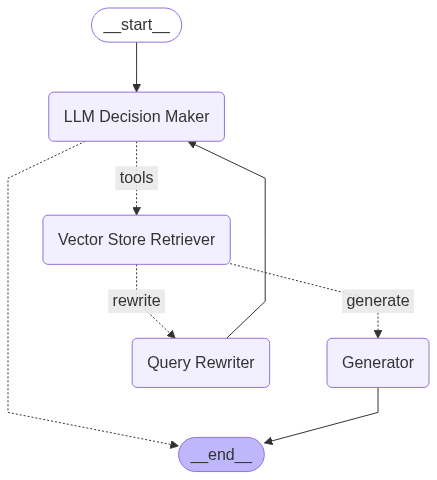

In [34]:
display(Image(app.get_graph().draw_mermaid_png()))